In [26]:
from __future__ import print_function, division
import numpy as np
import random
import math
%matplotlib inline
import matplotlib.pyplot as plt
fft = np.fft.fft
ifft = np.fft.ifft

Pascal's triangle can be thought of as a convlution of (1,1) repeatedly.

We can perform this convolution as multiplication in Fourier space

In [3]:
def pascal_row(n):
    x = [1,1] + [0] * (n-1)
    fx = fft(x)
    return np.round(ifft(fx ** n).real)

In [4]:
for i in range(10):
    print(pascal_row(i))

[ 1.  0.]
[ 1.  1.]
[ 1.  2.  1.]
[ 1.  3.  3.  1.]
[ 1.  4.  6.  4.  1.]
[  1.   5.  10.  10.   5.   1.]
[  1.   6.  15.  20.  15.   6.   1.]
[  1.   7.  21.  35.  35.  21.   7.   1.]
[  1.   8.  28.  56.  70.  56.  28.   8.   1.]
[   1.    9.   36.   84.  126.  126.   84.   36.    9.    1.]


Wikipedia mentions alternating values for a row can be found by fourier transformin sin(x) ^ n / x. Our step function is this convoluted by fft([0,....,0, 1]), ie the nyquist frequency, [1,-1,1,-1...]

Problem is that a top-hat function symmetrical about x=0 needs an odd-number of points - it's hard to make an even width top hat funcion (what values can the top hat be over to be a symmetric function? eg [1,0.5,0,...,0.5] is symmetric about origin, but [1,1,0,...] isn't and neither is [1,0,0..., 0, 1])

In [5]:
# [0,0,0,0,1,0,0,0] produces alternating +1,-1 in fourier space. 
# if we want to get alternating coeffs, we want to multiply by this is
# fourier = convolute in real
fft([0,0,0,0,1,0,0,0])

array([ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,
       -1.+0.j])

In [6]:
# So we should shift our top-hat function the middle and we'll see alternating signs?
# but that's AFTER raising to the power...
# this gives the same results but just rotated...
def pascal_row2(n):
    x = ([0] * ((n-1)//2)) + [1,1] + [0] * ((n-1)//2)
    fx = fft(x)
    return ifft(fx ** n).real

In [7]:
print(pascal_row2(8))

[  2.   8.  28.  56.  70.  56.  28.   8.]


In [8]:
# so what analytically is F[1100..0]?
# I think top-hat (centered would be [1100001])
# = sin(x) / x?
top_hat_fft = fft([1/3., 1/3.] + [0]*13 + [1/3.])
top_hat_fft

array([ 1.00000000 +0.00000000e+00j,  0.94925302 -2.49800181e-16j,
        0.80473785 -3.60822483e-16j,  0.58845562 -3.33066907e-16j,
        0.33333333 +0.00000000e+00j,  0.07821105 +1.11022302e-16j,
       -0.13807119 +3.88578059e-16j, -0.28258636 +8.32667268e-16j,
       -0.33333333 +0.00000000e+00j, -0.28258636 +2.49800181e-16j,
       -0.13807119 +3.60822483e-16j,  0.07821105 +3.33066907e-16j,
        0.33333333 +0.00000000e+00j,  0.58845562 -1.11022302e-16j,
        0.80473785 -3.88578059e-16j,  0.94925302 -8.32667268e-16j])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy-1.7.0-py2.7-macosx-10.6-intel.egg/numpy/core/numeric.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


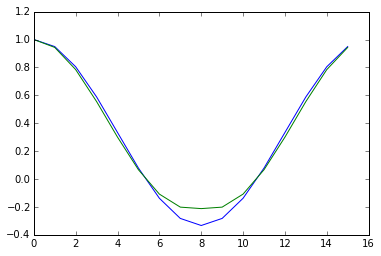

In [9]:
sinc = lambda x: np.sin(x)/x if x !=0 else 1.0
sincd = np.array([sinc(x*np.pi*3) for x in np.fft.fftfreq(16)])
sincd
#ifft(sincd)
plt.plot(zip(top_hat_fft, sincd))

Sinc function has first minimum of around -0.2, but we seem to get below that with the top_hat_fft (the blue curve above). So whay is top_hat_fft **NOT** a sinc function. It's close, but no cigar...

Is it because we're effectively fourier transforming repeated step functions. What if we evaluate sinc(x +/- nyquist) and add to result? 

The following works for odd widths:

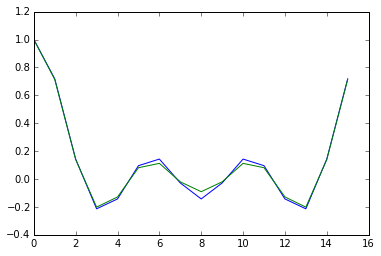

In [247]:
width = 7
num_channels = 16
top_hat_fft = fft([1/width] 
                  + [1/width] * (width//2)
                  + [0]*(num_channels - width) 
                  + [1/width] * (width//2))
top_hat_fft

def make_tophat_fft(top_hat_width, num_channels, harmonics=1):
    sincd = np.array([sinc(x*np.pi*top_hat_width) 
                      for x in np.fft.fftfreq(num_channels)])
    # sinc is symmetric 
    for harmonic in range(1, harmonics):
        for dirn in [-1, 1]:
            sincd += [sinc(dirn * x*np.pi*top_hat_width 
                           + harmonic* np.pi * top_hat_width) 
                      for x in np.fft.fftfreq(num_channels)]
    return sincd
# first is blue, second is green!
plt.plot(zip(top_hat_fft, make_tophat_fft(width, num_channels)))

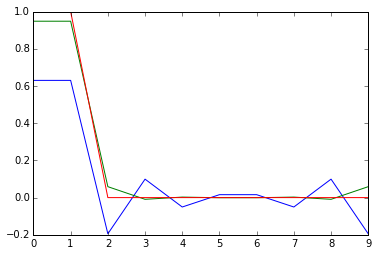

In [345]:
# So this works for a centered, odd-width top-hat function. 
# But we need an uncentered, 2-wide top hat function. We want to shift the top hat, 
# which means convolution in top-hat space, and multiplication in Pascal space.
# Hopefully our make_tophat_fft can give us arbitrary width top-hats, and we 
# should then just be a multiple away from the pascal line?

def make_shifted_tophat_fft(tophat_width, shift, num_channels, harmonics):
    return (
        np.exp(1j * shift * 2 * np.pi * np.fft.fftfreq(num_channels)) *
        make_tophat_fft(tophat_width, num_channels, harmonics) * tophat_width
         )

def make_shifted_tophat(tophat_width, shift, num_channels, harmonics):
    return ifft(make_shifted_tophat_fft(tophat_width, shift, num_channels, harmonics))

h=5
plt.plot(make_shifted_tophat(1, -0.5, 10, h).real)
# make_shifted_tophat works great with odd widths and integer shifts
# We actually want width 2 and shift of -0.5, which starts to make it a bit
# less exact. Odd;y we get better results without the harmonics here...
h = 1
plt.plot(make_shifted_tophat(2, -0.5, 10, h).real)
plt.plot([1,1] + [0] * 8)

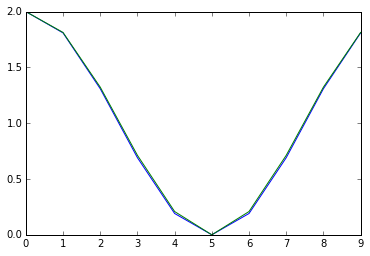

In [328]:
#How does make_shifted_tophat_fft(2, -0.5, 10, 1) compare with
def tophat_fft(n):
    x = [1,1] + [0] * (n-2)
    fx = fft(x)
    return fx

num_channels=10
a = tophat_fft(num_channels)
h = 9
#b = make_shifted_tophat_fft(2.0, -0.5, num_channels, h)
b = make_shifted_tophat_fft(2.0, 0, num_channels, h)
plt.plot(a.real) # blue
plt.plot(b.real)

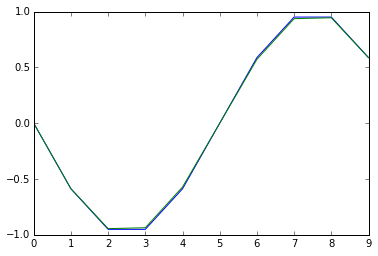

In [330]:
# this b seems to get phase very close...
h=1
b = np.pi * make_shifted_tophat_fft(2.0, -1 / 2 / np.pi, num_channels, h)

plt.plot(a.imag) # blue
plt.plot(b.imag)

We're definitely on the right track here, but the analytical solution is not as clean..

In [335]:
rown = 2
h=1
ifft(tophat_fft(rown + 1)**rown).real

array([ 1.,  2.,  1.])

In [336]:
ifft(make_shifted_tophat_fft(2, -0.5, rown+1, h) ** rown).real

array([ 1.10536067,  1.78927866,  1.10536067])

In [77]:
ifft(sincd)

array([  1.99972399e-01 +0.00000000e+00j,
         2.00043942e-01 +5.20417043e-17j,
         1.99684063e-01 +9.36750677e-17j,
         3.14747451e-04 -6.59194921e-17j,
        -3.96694244e-05 -6.93889390e-18j,
         1.69003180e-05 -1.04083409e-17j,
        -1.07240673e-05 -7.28583860e-17j,
         8.48860624e-06 -7.97972799e-17j,
        -7.89310299e-06 +0.00000000e+00j,
         8.48860624e-06 -1.73472348e-17j,
        -1.07240673e-05 -8.67361738e-17j,
         1.69003180e-05 -5.20417043e-17j,
        -3.96694244e-05 +6.93889390e-18j,
         3.14747451e-04 -2.42861287e-17j,
         1.99684063e-01 +6.59194921e-17j,   2.00043942e-01 +1.97758476e-16j])

#Fourier Multiplication 

In [154]:
def mult_lists(a, b):
    """
     Multiply the arrays of digits a,b by convolving a with b via a
    Fourier transform.
    A and b should have units in the first element, then base**1, base**2m etc.
    Eg 3,412 would be [2, 1, 4, 3]
    """
    out_size = len(a) + len(b)
    a = a + [0] * (out_size - len(a))
    b = b + [0] * (out_size - len(b))
    f = ifft(fft(a)*fft(b)).real
    return f

def to_digit_list(num, base=10):
    ret = []
    while num > 0:
        ret.append(num % base)
        num //= base
    return ret
        
def from_digit_list(nums, base=10):
    return sum(int(round(num)) * base**i for i,num in enumerate(nums))

In [155]:
to_digit_list(12121121219, 10)

[9, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1]

In [178]:
import random

def to_digit_list(num, base=10):
    ret = []
    while num > 0:
        ret.append(num % base)
        num //= base
    return ret
        
def from_digit_list(nums, base=10):
    return sum(int(round(num)) * base**i for i,num in enumerate(nums))

def fourier_mult(a, b):
    return from_digit_list(mult_lists(to_digit_list(a), to_digit_list(b)))

a=random.getrandbits(256)
b=random.getrandbits(256)
ab = a*b
abf = fourier_mult(a, b)
assert ab - abf == 0

In [177]:
import random
long(np.random.random(30))

TypeError: only length-1 arrays can be converted to Python scalars

In [162]:
import math
random.getrandbits(200)

251974217330697881331828676360296183712923143970808142327222L

In [137]:
def choose(n,r):
    return math.factorial(n)/math.factorial(r)/math.factorial(n-r)

In [142]:
def pascal_row_exact(n):
    return [choose(n,m) for m in range(n+1)]

In [153]:
[(n, sum(pascal_row(n) - pascal_row_exact(n))) for n in range(150)]

[(0, -1.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.0),
 (21, 0.0),
 (22, 0.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 0.0),
 (32, 0.0),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (39, 0.0),
 (40, 0.0),
 (41, 0.0),
 (42, 0.0),
 (43, 0.0),
 (44, 0.0),
 (45, 0.0),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (49, 0.0),
 (50, 2.0),
 (51, -2.0),
 (52, 6.0),
 (53, 3.0),
 (54, 30.0),
 (55, 48.0),
 (56, 111.0),
 (57, 251.0),
 (58, 557.0),
 (59, -56.0),
 (60, 2390.0),
 (61, 3658.0),
 (62, 6933.0),
 (63, -96.0),
 (64, 30886.0),
 (65, 61581.0),
 (66, 149612.0),
 (67, 272077.0),
 (68, 608443.0),
 (69, 863310.0),
 (70, 2460744.0),
 (71, -100155.0),
 (72, 7881842.0),
 (73, 20541271.0),
 (74, 550893.0),
 (75, 73517480.0),
 (76, 1471